In [159]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [160]:

def custom_activation(x):
    return tf.sin(x)


In [161]:
NN = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input((2,)),
        tf.keras.layers.Dense(units=32, activation=custom_activation),
        tf.keras.layers.Dense(units=32, activation=custom_activation),
        tf.keras.layers.Dense(units=32, activation=custom_activation),
        tf.keras.layers.Dense(units=1),
    ]
)

NN.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [162]:
optm = tf.keras.optimizers.Adam(learning_rate=0.001)
NN.compile(optimizer="Adam", loss="mean_squared_error")

In [163]:
tf_pi = tf.constant(np.pi)

def real_u(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

def f(x, y):
    return -2 * tf_pi * tf_pi * tf.sin(tf_pi * y) * tf.sin(tf_pi * x)

### Params

In [164]:
grid_size = (50, 50)
x_limits = (0, 2)
y_limits = (0, 2)
border_grid_size = (50, 50)
koef = 2

In [165]:
def ode_system(coord, net, border):
    border = tf.constant(border, dtype=tf.float32)
    coord = tf.constant(coord, dtype=tf.float32)
    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape_first:
        tape_first.watch(coord)
        u = net(coord)
        u_coord = tape_first.gradient(u, coord)
        du_dx = u_coord[..., 0]
        du_dy = u_coord[..., 1]
    du_dc_dc = tape_first.gradient(u_coord, coord)
    du_dxdx = du_dc_dc[..., 0]
    du_dydy = du_dc_dc[..., 1]
    del tape_first
    x = coord[..., 0]
    y = coord[..., 1]
    ode_loss = du_dxdx + du_dydy - f(x, y)
    IC_loss = net(border) - tf.zeros((len(border), 1))
    square_loss = tf.square(ode_loss) + koef * tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

In [166]:
x = np.linspace(x_limits[0], x_limits[1], border_grid_size[0])
y = np.linspace(y_limits[0], y_limits[1], border_grid_size[1])
# y = np.random.uniform(1, 10, 10)
x, y = np.meshgrid(x, y)
train_coord = np.column_stack((x.flatten(), y.flatten()))

border = train_coord.reshape(border_grid_size[0], border_grid_size[1], 2)
border_01 = np.append(border[0], border[0][..., [1, 0]])
border_02 = np.append(border[border_grid_size[0] - 1], border[border_grid_size[0] - 1][..., [1, 0]])
border = np.append(border_01, border_02).reshape(border_grid_size[0] * 4, 2)

x = np.linspace(x_limits[0], x_limits[1], grid_size[0])
y = np.linspace(y_limits[0], y_limits[1], grid_size[1])

x, y = np.meshgrid(x, y)
train_coord = np.column_stack((x.flatten(), y.flatten()))
# train_coord = x
train_loss_record = []

93.57505 0.08944034576416016
81.813484 3.012636423110962
26.289034 5.845468521118164
15.606195 8.691317081451416
10.454365 11.674695253372192
6.1075635 14.535625457763672
3.2533298 17.12881827354431
1.8734112 19.701743125915527
1.1392174 22.245619535446167
0.7012451 24.742037773132324
0.48387688 27.6431941986084
0.36587796 30.226165294647217
0.2933828 32.81026077270508
0.24723844 35.375457525253296
0.20944344 37.96394634246826
0.18115486 40.45384740829468
0.15727405 43.00203037261963
0.13764104 45.49169898033142
0.120297715 48.00237321853638
0.105044216 50.50425744056702
0.09236956 52.99033308029175


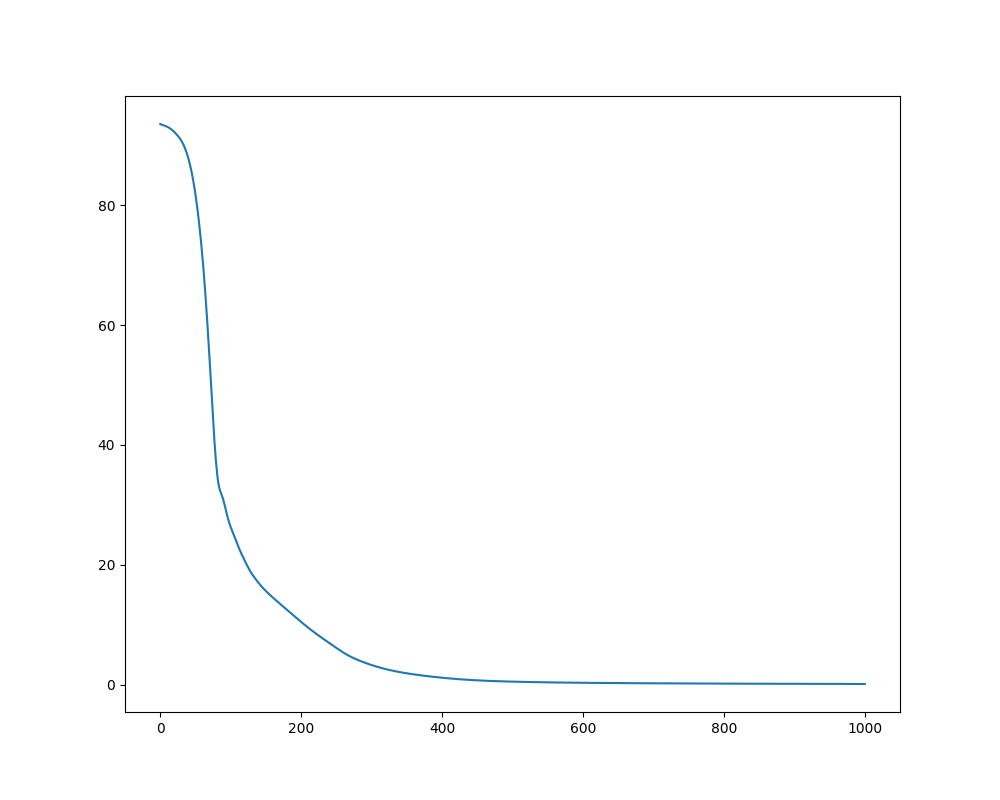

In [167]:
import time

start = time.time()

for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_coord, NN, border)
        train_loss_record.append(train_loss)

    grad_w = tape.gradient(train_loss, NN.trainable_variables)
    optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 50 == 0:
        print(train_loss.numpy(), time.time() - start)
        
        if train_loss < 0.1:
            break

plt.figure(figsize=(10, 8))
plt.plot(train_loss_record)
plt.show()

In [168]:
# NN.save("model.keras")
# NN = tf.keras.models.load_model("my_model.keras")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


[(0.0, 2.0),
 (0.0, 2.0),
 Text(0.5, 0, 'X'),
 Text(0.5, 0.5, 'Y'),
 Text(0.5, 0, 'Z')]

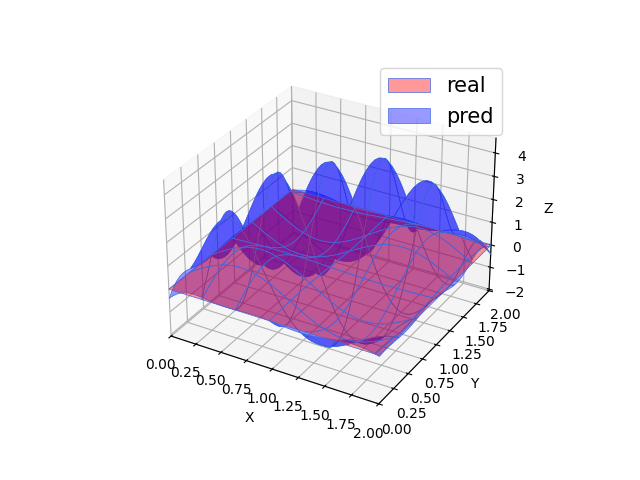

In [169]:
%matplotlib widget
test_x = np.linspace(x_limits[0], x_limits[1], grid_size[0])
test_y = np.linspace(x_limits[0], x_limits[1], grid_size[1])
test_x, test_y = np.meshgrid(test_x, test_y)

train_u = real_u(x, y)
true_u = real_u(test_x, test_y)
test_coord = np.column_stack((test_x.flatten(), test_y.flatten()))
pred_coord = list()
for _x in x[0]:
    for _y in x[0]:
        pred_coord.append([_x, _y])
pred_u = NN.predict(np.array(pred_coord)).ravel().reshape(grid_size[0], grid_size[1])
ax = plt.figure().add_subplot(projection="3d")
ax.plot_surface(
    test_x,
    test_y,
    true_u,
    edgecolor="royalblue",
    lw=0.5,
    rstride=8,
    cstride=8,
    alpha=0.4,
    # cmap="BuGn",
    facecolor="red",
    label="real"
)
ax.plot_surface(
    x,
    y,
    pred_u,
    edgecolor="royalblue",
    lw=0.5,
    rstride=8,
    cstride=8,
    alpha=0.4,
    # cmap="plasma",
    facecolor="blue",
    label="pred",
)
# ax.scatter(x, y, train_u, s=0.5, label="train")
ax.legend(fontsize=15)
ax.set(xlim=x_limits, ylim=y_limits, xlabel="X", ylabel="Y", zlabel="Z")

# Accuracy calculation

In [170]:
# Calculate the number of correct predictions
correct_predictions = np.sum(np.isclose(pred_u, true_u, rtol=0.1))

# Calculate the total number of predictions
total_predictions = np.prod(grid_size)

# Calculate the accuracy
accuracy = correct_predictions / total_predictions

print("Accuracy:", accuracy)

Accuracy: 0.0396
